# 16 - ADER-FD

This notebook demonstrates the implementation of a finite-difference scheme for solving the first-order formulation of the acoustic wave equation using ADER (Arbitrary-order-accuracy via DERivatives) time integration. This enables a temporal discretisation up the order of the spatial discretisation, whilst preventing the grid-grid decoupling (often referred to as checkerboarding) associated with solving first-order systems of equations on a single finite-difference grid.

The method is detailed in "Fast High Order ADER Schemes for Linear Hyperbolic Equations" by Schwartzkopf et al. (https://doi.org/10.1016/j.jcp.2003.12.007).

The state vector is defined as

$\mathbf{U} = \begin{bmatrix} p \\ \mathbf{v} \end{bmatrix}$,

where $p$ is pressure, and $\mathbf{v}$ is particle velocity. Taking a Taylor-series expansion of $\mathbf{U}(t+\Delta t)$ at time $t$, one obtains

$\mathbf{U}(t+\Delta t) = \mathbf{U}(t) + \Delta t\frac{\partial \mathbf{U}}{\partial t}(t) + \frac{\Delta t^2}{2}\frac{\partial^2 \mathbf{U}}{\partial t^2}(t) + \frac{\Delta t^3}{6}\frac{\partial^3 \mathbf{U}}{\partial t^3}(t) + \dots$.

Using the governing equations

$\frac{\partial \mathbf{U}}{\partial t} = \begin{bmatrix}\rho c^2 \boldsymbol{\nabla}\cdot\mathbf{v} \\ \frac{1}{\rho}\boldsymbol{\nabla}p \end{bmatrix}$,

expressions for higher-order time derivatives of the state vector are derived in terms of spatial derivatives. For example, taking the second derivative of the state vector with respect to time

$\frac{\partial^2 \mathbf{U}}{\partial t^2} = \begin{bmatrix}\rho c^2 \boldsymbol{\nabla}\cdot\frac{\partial \mathbf{v}}{\partial t} \\ \frac{1}{\rho}\boldsymbol{\nabla}\frac{\partial p}{\partial t} \end{bmatrix}$.

Substituting the temporal derivatives on the right hand side for the expressions given in the governing equations

$\frac{\partial^2 \mathbf{U}}{\partial t^2} = \begin{bmatrix}\rho c^2 \boldsymbol{\nabla}\cdot\left(\frac{1}{\rho}\boldsymbol{\nabla}p\right) \\ \frac{1}{\rho}\boldsymbol{\nabla}\left(\rho c^2 \boldsymbol{\nabla}\cdot\mathbf{v}\right) \end{bmatrix}$.

Assuming constant $c$ and $\rho$, this simplifies to

$\frac{\partial^2 \mathbf{U}}{\partial t^2} = \begin{bmatrix}c^2 \nabla^2 p \\ c^2\boldsymbol{\nabla}\left(\boldsymbol{\nabla}\cdot\mathbf{v}\right) \end{bmatrix}$.

This process is iterated to obtain equations for the required higher-order temporal derivatives.

High-order explicit timestepping is achieved by substituting these expressions into the Taylor expansion, truncated at the desired temporal discretisation order. As such, the order of the temporal discretisation can be increased to that of the spatial discretisation.

In [1]:
#NBVAL_IGNORE_OUTPUT
# Necessary imports
import devito as dv
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from examples.seismic import TimeAxis, RickerSource

To begin, we set up the `Grid`. Note that no staggering is specified for the `Function`s, being unnecessary in this case due to the coupling of solution variables present in the ADER-FD update equations.

In [2]:
# 1km x 1km grid
grid = dv.Grid(shape=(201, 201), extent=(1000., 1000.))
p = dv.TimeFunction(name='p', grid=grid, space_order=16)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=16, staggered=(None, None))

Material parameters are specified as in the staggered case. Note that if one assumes non-constant material parameters when deriving higher-order time derivatives in terms of spatial derivatives, the resultant expressions will contain derivatives of material parameters. As such, it will be necessary to set the `space_order` of the `Function`s containing material parameters accordingly, and values may need extending into the halo using the  `data_with_halo` view.

In [3]:
# Material parameters
c = dv.Function(name='c', grid=grid)
rho = dv.Function(name='rho', grid=grid)

c.data[:] = 1.5
c.data[:, :150] = 1.25
c.data[:, :100] = 1.
c.data[:, :50] = 0.75

rho.data[:] = c.data[:]

# Define bouyancy for shorthand
b = 1/rho
# Define celerity shorthands
c2 = c**2
c4 = c**4

Now we will specify each of the temporal derivatives required for a 4th-order ADER timestepping scheme. Note that for conciseness, the derivations assume constant material parameters.

In [4]:
# dv.grad(dv.div(v)) is not the same as expanding the continuous operator and then discretising
# This is because dv.grad(dv.div(v)) applies a gradient stencil to a divergence stencil
def graddiv(f):
    return sp.Matrix([[f[0].dx2 + f[1].dxdy],
                      [f[0].dxdy + f[1].dy2]])

def lapdiv(f):
    return f[0].dx3 + f[0].dxdy2 + f[1].dx2dy + f[1].dy3

def gradlap(f):
    return sp.Matrix([[f.dx3 + f.dxdy2],
                      [f.dx2dy + f.dy3]])

def gradlapdiv(f):
    return sp.Matrix([[f[0].dx4 + f[0].dx2dy2 + f[1].dx3dy + f[1].dxdy3],
                      [f[0].dx3dy + f[0].dxdy3 + f[1].dx2dy2 + f[1].dy4]])\

def biharmonic(f):
    return f.dx4 + 2*f.dx2dy2 + f.dy4

# First time derivatives
pdt = rho*c2*dv.div(v)
vdt = b*dv.grad(p)

# Second time derivatives
pdt2 = c2*p.laplace
vdt2 = c2*graddiv(v)

# Third time derivatives
pdt3 = rho*c4*lapdiv(v)
vdt3 = c2*b*gradlap(p)

# Fourth time derivatives
pdt4 = c4*biharmonic(p)
vdt4 = c4*gradlapdiv(v)

Define the model timestep.

In [5]:
# Model timestep
op_dt = 0.85*np.amin(grid.spacing)/np.amax(c.data)  # Courant number of 0.85

Now define the update equations for 4th-order ADER timestepping.

In [6]:
dt = grid.stepping_dim.spacing

# Update equations (4th-order ADER timestepping)
eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2 + (dt**3/6)*pdt3 + (dt**4/24)*pdt4)
eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2 + (dt**3/6)*vdt3 + (dt**4/24)*vdt4)

Add a source.

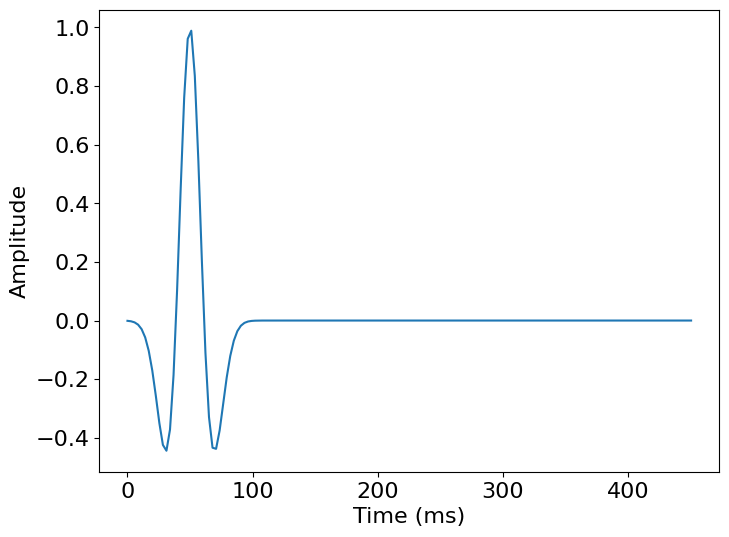

In [7]:
#NBVAL_IGNORE_OUTPUT
t0 = 0.  # Simulation starts a t=0
tn = 450.  # Simulation last 0.45 seconds (450 ms)

time_range = TimeAxis(start=t0, stop=tn, step=op_dt)

f0 = 0.020  # Source peak frequency is 20Hz (0.020 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = np.array(grid.extent) * .5

# We can plot the time signature to see the wavelet
src.show()

Finally we can run our propagator.

In [8]:
#NBVAL_IGNORE_OUTPUT
src_term = src.inject(field=p.forward, expr=src)

op = dv.Operator([eq_p, eq_v] + src_term)
op.apply(dt=op_dt)

Operator `Kernel` ran in 0.06 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.055729999999999974, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0006119999999999994, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

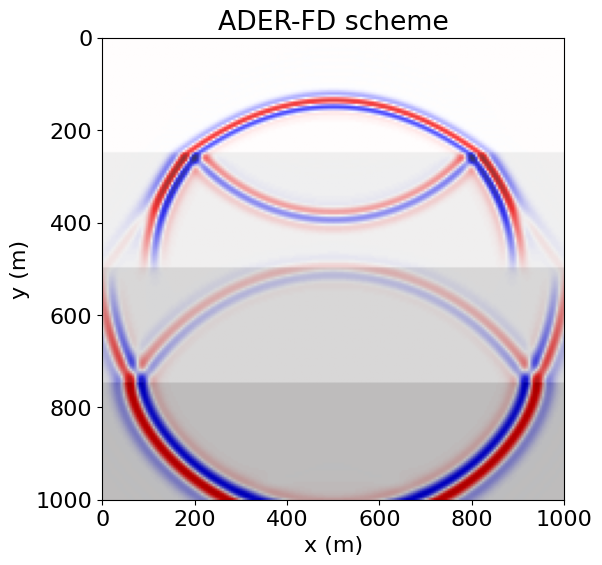

In [9]:
#NBVAL_IGNORE_OUTPUT
extent = [0, 1000, 1000, 0]
vmax = np.abs(np.amax(p.data[-1]))
plt.imshow(c.data.T, cmap='Greys', extent=extent)
plt.imshow(p.data[-1].T, cmap='seismic', alpha=0.75, extent=extent, vmin=-vmax, vmax=vmax)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("ADER-FD scheme")
plt.show()

Using a staggered discretisation to solve the first-order acoustic wave equation with the same parameterisation:

In [10]:
#NBVAL_IGNORE_OUTPUT
ps = dv.TimeFunction(name='ps', grid=grid, space_order=16, staggered=dv.NODE)
vs = dv.VectorTimeFunction(name='vs', grid=grid, space_order=16)

# First time derivatives
psdt = rho*c2*dv.div(vs.forward)
vsdt = b*dv.grad(ps)

eq_ps = dv.Eq(ps.forward, ps + dt*psdt)
eq_vs = dv.Eq(vs.forward, vs + dt*vsdt)

src_term_s = src.inject(field=ps.forward, expr=src)

ops = dv.Operator([eq_vs, eq_ps] + src_term_s)
ops.apply(dt=op_dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.013889000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0006609999999999988, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

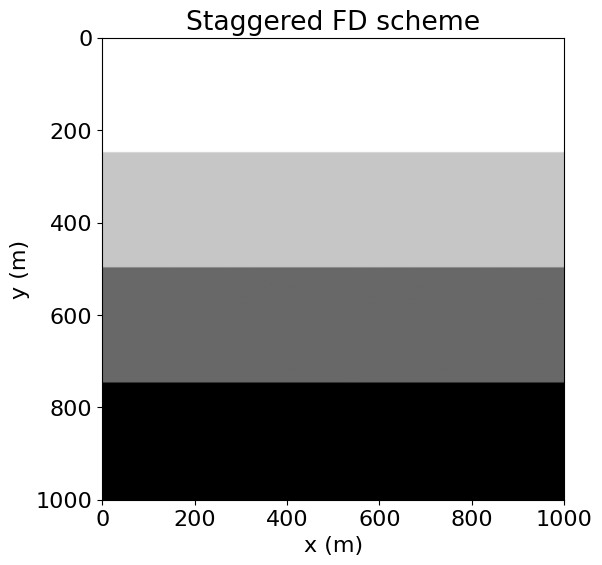

In [11]:
#NBVAL_IGNORE_OUTPUT
vmax = np.abs(np.amax(ps.data[-1]))
plt.imshow(c.data.T, cmap='Greys', extent=extent)
plt.imshow(ps.data[-1].T, cmap='seismic', alpha=0.75, extent=extent, vmin=-vmax, vmax=vmax)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Staggered FD scheme")
plt.show()

It is apparent that the staggered scheme with leapfrog timestepping is unstable with the timestep used in the unstaggered scheme with ADER timestepping.

In [12]:
np.amax(ps.data[-1])  # Printing the maximum shows that the wavefield has gone to NaN

Data(nan, dtype=float32)

Reducing the timestep for comparison:

In [13]:
#NBVAL_IGNORE_OUTPUT
# Reset the fields
p.data[:] = 0
ps.data[:] = 0

v[0].data[:] = 0
v[1].data[:] = 0
vs[0].data[:] = 0
vs[1].data[:] = 0

new_dt = 0.5*np.amin(grid.spacing)/np.amax(c.data)  # Courant number of 0.5

op.apply(dt=new_dt, src=src.resample(dt=new_dt))
ops.apply(dt=new_dt, src=src.resample(dt=new_dt))

Operator `Kernel` ran in 0.11 s


Operator `Kernel` ran in 0.03 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.020704, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0009489999999999966, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

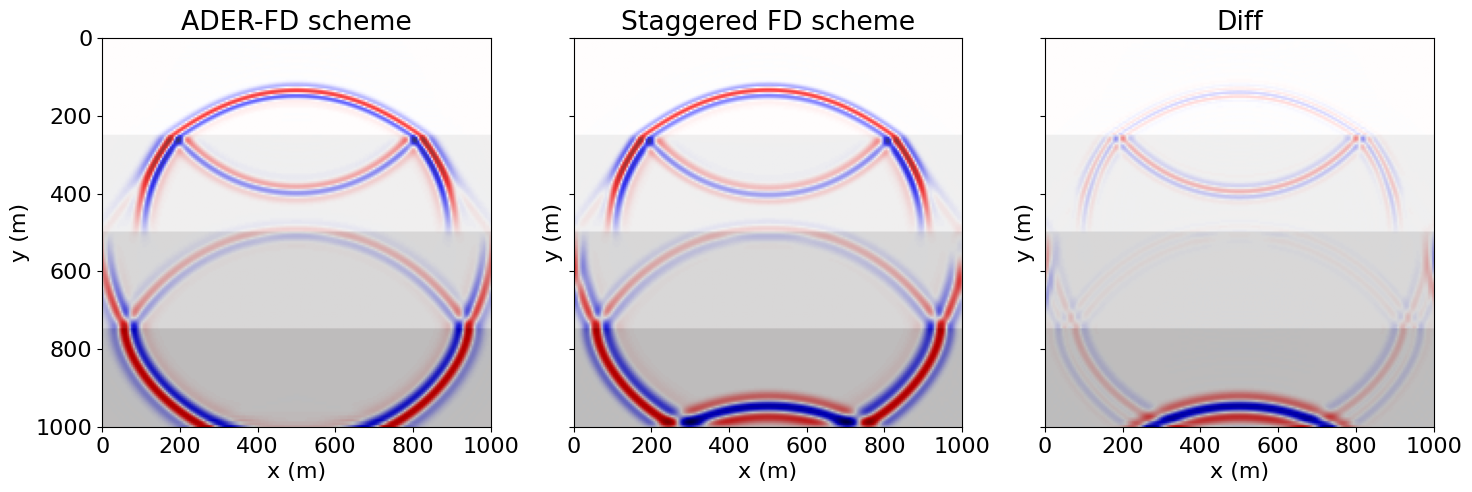

In [14]:
#NBVAL_IGNORE_OUTPUT
vmax = np.amax(np.abs(p.data[-1]))

fig, ax = plt.subplots(1, 3, figsize=(15, 10), tight_layout=True, sharey=True)

# Note that due to the leapfrog timestepping, fields need to be accessed at different timesteps
ax[0].imshow(c.data.T, cmap='Greys', extent=extent)
im_p = ax[0].imshow(p.data[1].T, cmap='seismic', alpha=0.75, extent=extent, vmin=-vmax, vmax=vmax)
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")
ax[0].title.set_text("ADER-FD scheme")

ax[1].imshow(c.data.T, cmap='Greys', extent=extent)
ax[1].imshow(ps.data[0].T, cmap='seismic', alpha=0.75, extent=extent, vmin=-vmax, vmax=vmax)
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("y (m)")
ax[1].title.set_text("Staggered FD scheme")

ax[2].imshow(c.data.T, cmap='Greys', extent=extent)
ax[2].imshow(ps.data[0].T - p.data[1].T, cmap='seismic', alpha=0.75, extent=extent, vmin=-vmax, vmax=vmax)
ax[2].set_xlabel("x (m)")
ax[2].set_ylabel("y (m)")
ax[2].title.set_text("Diff")

plt.show()

Note the damping of the field at the boundaries when using the ADER scheme. ADER-FD schemes exhibit numerical diffusion when encountering non-smooth solutions, as is the case at the zero padding surrounding the grid. This occurs in the absence of any damping boundary conditions, hence the presence of reflections in the staggered case.

In [15]:
assert(np.isclose(np.linalg.norm(p.data), 1.6494513))
assert(np.isclose(np.linalg.norm(ps.data), 1.8412739))